## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [9]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL
import copy
import pytorch_lightning as pl
sys.path.insert(0, '../../')
from guided_diffusion.script_util import (
    seed_all,
)
import importlib

# Sample utils
sys.path.insert(0, '../')
from sample_utils import ckpt_utils, params_utils, vis_utils, file_utils, img_utils, inference_utils, mani_utils

In [19]:
# Define loading settings 
cfg_name = "cond_img64_by_deca_arcface.yaml"
log_dir = "cond_img64_by_deca_arcface"
set_ = "valid"
batch_size = 20
seed = 47
seed_all(seed)
if set_ == 'itw':
    img_dataset_path = "../../itw_images/aligned/"
elif set_ == 'train' or set_ == 'valid':
    img_dataset_path = f"/data/mint/ffhq_256_with_anno/ffhq_256/{set_}/"
else: raise NotImplementedError

# Checkpoint loader
step = "050000"
ckpt_selector = "ema"
ckpt_loader = ckpt_utils.CkptLoader(log_dir=log_dir, cfg_name=cfg_name)
cfg = ckpt_loader.cfg
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=ckpt_selector, step=step)


[#] Model Path :  ['/data/mint/model_logs_mount/v9/cond_img64_by_deca_arcface/']
['/home/mint/guided-diffusion/config/Various_condition_on_Image/cond_img64_by_deca_arcface.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/Various_condition_on_Image/cond_img64_by_deca_arcface.yaml')

[#] Available ckpt :  ['_000000.pt', '_050000.pt', '_100000.pt', '_150000.pt', '_200000.pt', '_250000.pt', '_300000.pt', '_350000.pt', '_400000.pt', '_450000.pt', '_500000.pt', '_550000.pt', '_600000.pt', '_650000.pt', '_700000.pt']
[#] Loading.../data/mint/model_logs_mount/v9/cond_img64_by_deca_arcface//ImgCond_ema_0.9999_050000.pt


Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-faceemb-anno.txt


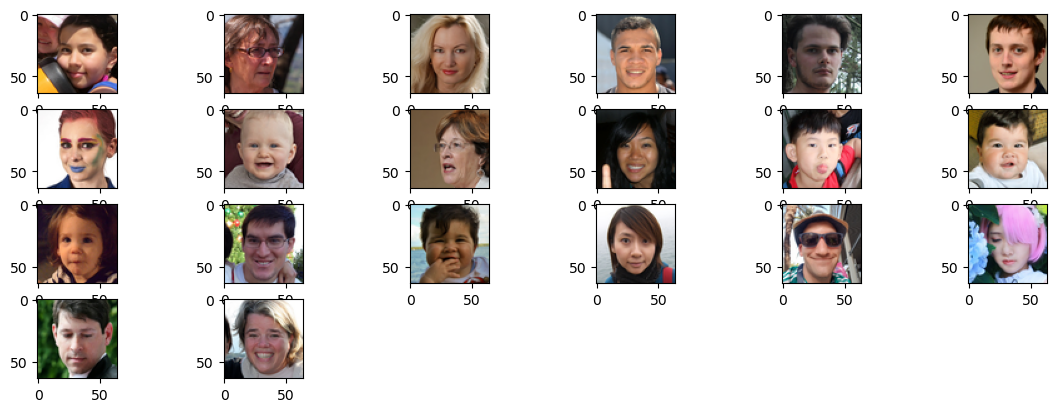

In [11]:
# Load params
params_set = params_utils.get_params_set(set=set_, cfg=cfg)

rand_idx = np.random.choice(a=range(len(list(params_set.keys()))), replace=False, size=batch_size)
img_path = file_utils._list_image_files_recursively(img_dataset_path)
img_path = [img_path[r] for r in rand_idx]
img_name = [path.split('/')[-1] for path in img_path]

# Load condition & Images into model_kwargs
model_kwargs = mani_utils.load_condition(params_set, img_name)
images = mani_utils.load_image(all_path=img_path, cfg=cfg, vis=True)['image']
model_kwargs.update({'image_name':img_name, 'image':images})

In [17]:
base_idx = 11
mode = {'init_noise':'vary_noise', 'cond_params':'vary_cond'}
interchange = None

# Input 
init_noise = inference_utils.get_init_noise(n=batch_size, mode='fixed_noise', img_size=cfg.img_model.image_size, device=ckpt_loader.device)
cond = model_kwargs.copy()

# Finalize the cond_params
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light', 'image'], device=ckpt_loader.device)
img_tmp = cond['image'].clone()

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'light', 'faceemb']
(20, 698)


In [18]:
# Reverse
pl_reverse_sampling = inference_utils.PLReverseSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
reverse_ddim_sample = pl_reverse_sampling(x=cond['image'], model_kwargs=cond)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Forward
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=cond)

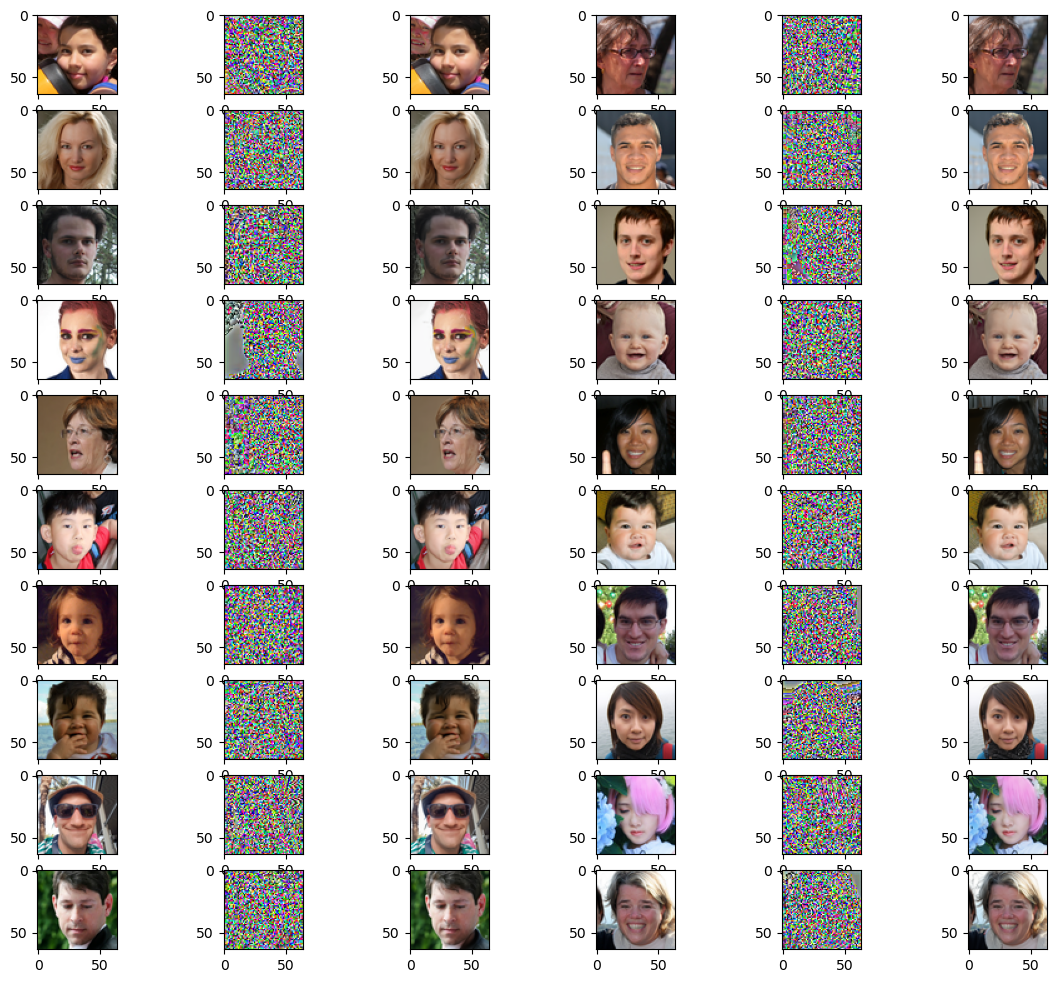

In [23]:
# Visualization
fig = vis_utils.plot_sample(img=cond['image'], reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])
fig.suptitle(f"""Reverse Sampling : set={set}, ckpt_selector={ckpt_selector}, step={step}, cfg={cfg_name},
                model={log_dir}, seed={seed}, base_idx={base_idx}
            """, x=0.1, y=0.95, horizontalalignment='left', verticalalignment='top',)
plt.show()

# Linear Classifier

In [ ]:
# TODO